In [8]:
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [9]:
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 15000""", con) 

def partition(x):
    if x < 3:
        return 0
    return 1
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
#print("Number of data points in our data", filtered_data.shape)
print(filtered_data.head(10))

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
5   6  B006K2ZZ7K   ADT0SRK1MGOEU                   Twoapennything   
6   7  B006K2ZZ7K  A1SP2KVKFXXRU1                David C. Sullivan   
7   8  B006K2ZZ7K  A3JRGQVEQN31IQ               Pamela G. Williams   
8   9  B000E7L2R4  A1MZYO9TZK0BBI                         R. James   
9  10  B00171APVA  A21BT40VZCCYT4                    Carol A. Reed   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                  

In [10]:
filtered_data.to_excel('C:\\Users\\Manisai\\Desktop\\amazon_ms.xlsx', index = False)

In [12]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)
display['COUNT(*)'].sum()

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
#print(display.head())

sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)

(14470, 10)


In [13]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
from bs4 import BeautifulSoup
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
fscore=final['Score'].tolist() 

100%|██████████| 14470/14470 [00:11<00:00, 1288.67it/s]


In [15]:
ms=['bad','worst','fake','unsatisfied','poor','rout','routed','foil','foiled']
i=0
while(i<(len(preprocessed_reviews))):
    if(fscore[i]==1):
        for j in ms:
            if(j in preprocessed_reviews[i]):
                preprocessed_reviews.pop(i)
                fscore.pop(i)
                i=-1
                break
    i+=1

In [16]:
print(len(preprocessed_reviews))
vectorizer = TfidfVectorizer(ngram_range=(1,2))
pre = vectorizer.fit_transform(preprocessed_reviews)
print(pre.shape)
print(len(vectorizer.get_feature_names()))

13884
(13884, 319936)
319936


In [17]:
from sklearn.preprocessing import LabelEncoder
X_train, X_test, y_train, y_test = train_test_split(pre, fscore, train_size=0.55,test_size=0.45, random_state=101)
encoder=LabelEncoder()
encoder.fit(y_train)
y_train=encoder.transform(y_train)
encoder.fit(y_test)
y_test=encoder.transform(y_test)

In [18]:
y_train

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [19]:
import keras 
from keras.models import Sequential 
from keras.layers import Dense, Dropout 
from keras.optimizers import RMSprop 

import numpy as np

Using TensorFlow backend.


In [20]:
model = Sequential() 
model.add(Dense(512, activation = 'relu', input_shape = (319936,))) 
model.add(Dropout(0.2)) 
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2)) 
model.add(Dense(1, activation = 'relu'))

In [21]:
model.compile(loss = 'binary_crossentropy',     
   optimizer = RMSprop(), 
   metrics = ['accuracy'])

In [ ]:
history = model.fit(
   X_train, y_train, 
   batch_size = 128, 
   epochs = 2, 
   verbose = 1, 
   validation_data = (X_test, y_test)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 7636 samples, validate on 6248 samples
Epoch 1/2
 128/7636 [..............................] - ETA: 1:19:54 - loss: 10.9680 - accuracy: 0.1250

In [11]:
print(len(y_test))

6248


In [12]:
print((X_train.shape),X_test.shape)

(7636, 319936) (6248, 319936)


In [13]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
max1=0;in1=0
for i in range(-5,4,1):
    clf = BernoulliNB(alpha=10**i)
    clf.fit(X_train,y_train)
    #print(clf.predict(X_test))
    k=accuracy_score(y_test,clf.predict(X_test))
    print(k,"for alpha =",10**i)
    if(k>=max1):
        max1=k;in1=i

0.8793213828425096 for alpha = 1e-05
0.8770806658130602 for alpha = 0.0001
0.8633162612035852 for alpha = 0.001
0.7924135723431498 for alpha = 0.01
0.7666453265044815 for alpha = 0.1
0.8314660691421255 for alpha = 1
0.8367477592829705 for alpha = 10
0.8367477592829705 for alpha = 100
0.8367477592829705 for alpha = 1000


In [34]:
print("Max accuracy from Naive Bayes is from alpha =",in1," and accuracy =",max1)


Max accuracy from Naive Bayes is from alpha = -2  and accuracy = 0.8842829705505761


In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
max1=0;in1=0
for i in range(76,91):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train,y_train)
    #print(neigh.predict(X_test))
    k=accuracy_score(y_test,neigh.predict(X_test))
    print(k," accuracy for alpha =",i)
    if(k>max1):
        max1=k;in1=i
print("Max accuracy from Naive Bayes is from alpha =",in1," and accuracy =",max1)

0.8381882202304738  accuracy for alpha = 76
0.8378681177976952  accuracy for alpha = 77
0.8380281690140845  accuracy for alpha = 78
0.8378681177976952  accuracy for alpha = 79
0.8380281690140845  accuracy for alpha = 80
0.8380281690140845  accuracy for alpha = 81
0.8381882202304738  accuracy for alpha = 82
0.8380281690140845  accuracy for alpha = 83
0.838348271446863  accuracy for alpha = 84
0.8378681177976952  accuracy for alpha = 85
0.8380281690140845  accuracy for alpha = 86
0.8378681177976952  accuracy for alpha = 87
0.8380281690140845  accuracy for alpha = 88
0.8378681177976952  accuracy for alpha = 89
0.8380281690140845  accuracy for alpha = 90
Max accuracy from Naive Bayes is from alpha = 84  and accuracy = 0.838348271446863


In [14]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.predict(X_test)
accuracy_score(y_test,clf.predict(X_test))

0.8516325224071702

In [15]:
clf.predict_proba(X_test)

array([[0.07407358, 0.92592642],
       [0.05787595, 0.94212405],
       [0.15079848, 0.84920152],
       ...,
       [0.05663731, 0.94336269],
       [0.22122314, 0.77877686],
       [0.23550734, 0.76449266]])

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,n_informative=2, n_redundant=0,random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=5, random_state=0)

In [17]:
clf.fit(X_train,y_train)
print(clf.predict(X_test))
accuracy_score(y_test,clf.predict(X_test))

[1 1 1 ... 1 1 1]


0.8367477592829705

In [18]:
from sklearn import tree
model = tree.DecisionTreeClassifier()
model.fit(X_train,y_train)
predic = model.predict(X_test)
accuracy = accuracy_score(y_test, predic)
accuracy

0.854673495518566

[Text(266.8371443204957, 216.91478260869565, 'X[1312] <= 0.006\ngini = 0.276\nsamples = 7636\nvalue = [1263, 6373]'),
 Text(266.016948718666, 215.86434782608694, 'X[12775] <= 0.019\ngini = 0.257\nsamples = 7508\nvalue = [1135, 6373]'),
 Text(213.56583881988172, 214.81391304347827, 'X[21447] <= 0.055\ngini = 0.144\nsamples = 3676\nvalue = [288, 3388]'),
 Text(212.745643218052, 213.76347826086956, 'X[5394] <= 0.19\ngini = 0.14\nsamples = 3665\nvalue = [277, 3388]'),
 Text(209.36333757583878, 212.71304347826086, 'X[5397] <= 0.063\ngini = 0.134\nsamples = 3650\nvalue = [264, 3386]'),
 Text(206.69970430056077, 211.66260869565218, 'X[9155] <= 0.072\ngini = 0.13\nsamples = 3639\nvalue = [254, 3385]'),
 Text(203.8330245554939, 210.61217391304348, 'X[3251] <= 0.288\ngini = 0.125\nsamples = 3624\nvalue = [243, 3381]'),
 Text(203.01282895366418, 209.56173913043477, 'X[8465] <= 0.191\ngini = 0.122\nsamples = 3617\nvalue = [236, 3381]'),
 Text(199.7400562690195, 208.51130434782607, 'X[1254] <= 0.07

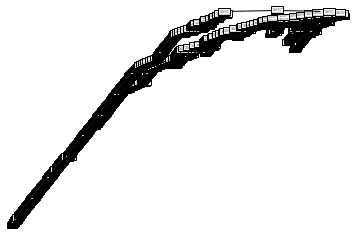

In [26]:

tree.plot_tree(model) 


In [19]:
y_test_predict_proba =model.predict_proba(X_test)[:, 1]
#print(len(y_test_predict_proba),(y_test))
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=15)

In [57]:
fraction_of_positives


array([0.48975189, 0.89719977])

In [58]:
mean_predicted_value

array([0.        , 0.99932135])

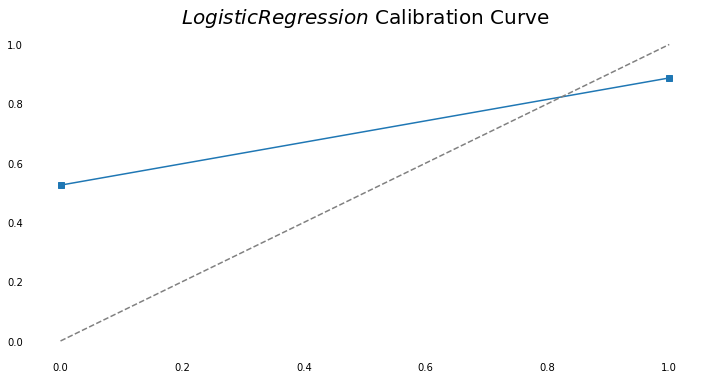

In [31]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("$LogisticRegression$ Calibration Curve", fontsize=20); pass

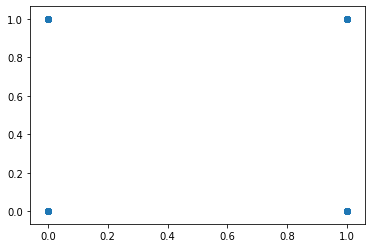

In [60]:
import matplotlib.pyplot as plt
plt.scatter(y_test, predic)